## ThinkDSP

This notebook contains code examples from Chapter 5: Autocorrelation

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

To investigate serial correlation of signals, let's start with a sine wave at 440 Hz.

In [3]:
from thinkdsp import SinSignal

def make_sine(offset):
    signal = SinSignal(freq=440, offset=offset)
    wave = signal.make_wave(duration=0.5, framerate=10000)
    return wave

I'll make two waves with different phase offsets.

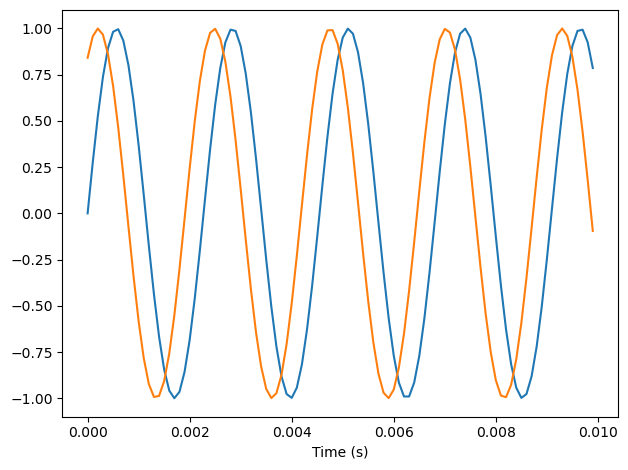

In [4]:
wave1 = make_sine(offset=0)
wave2 = make_sine(offset=1)

wave1.segment(duration=0.01).plot()
wave2.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

The two waves appears correlated: when one is high, the other is usually high, too.

We can use `np.corrcoef` to compute the correlation matrix.

In [5]:
print(np.corrcoef(wave1.ys, wave2.ys))

[[1.         0.54030231]
 [0.54030231 1.        ]]


The diagonal elements are the correlations of the waves with themselves, which is why they are 1.
The off-diagonal elements are the correlations between the two waves.  In this case, 0.54 indicates that there is a moderate correlation between these waves.

The correlation matrix is more interesting when there are more than two waves.  With only two waves, there is really only one number in the matrix we care about.

` Wave` provides `corr`, which computes the correlation between waves:

In [6]:
wave1.corr(wave2)

0.5403023058681397

To investigate the relationship between phase offset and correlation, I'll make an interactive function that computes correlation for each offset:

In [7]:
def compute_corr(offset):
    wave1 = make_sine(offset=0)
    wave2 = make_sine(offset=-offset)

    wave1.segment(duration=0.01).plot()
    wave2.segment(duration=0.01).plot()
    
    corr = wave1.corr(wave2)
    print('corr =', corr)
    
    decorate(xlabel='Time (s)')

The following interaction plots waves with different phase offsets and prints their correlations:

In [8]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

PI2 = np.pi * 2
slider = widgets.FloatSlider(min=0, max=PI2, value=1)
interact(compute_corr, offset=slider);

interactive(children=(FloatSlider(value=1.0, description='offset', max=6.283185307179586), Output()), _dom_cla…

Finally, we can plot correlation as a function of offset:

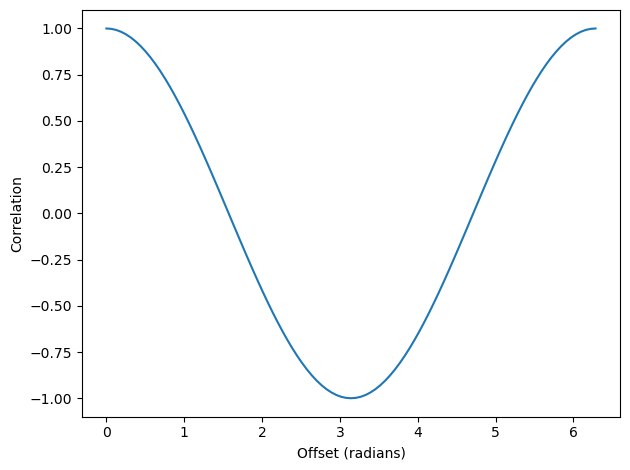

In [9]:
offsets = np.linspace(0, PI2, 101)

corrs = []
for offset in offsets:
    wave2 = make_sine(offset)
    corr = np.corrcoef(wave1.ys, wave2.ys)[0, 1]
    corrs.append(corr)
    
plt.plot(offsets, corrs)
decorate(xlabel='Offset (radians)',
         ylabel='Correlation')

That curve is a cosine.

Next we'll compute serial correlations for different kinds of noise.

In [10]:
def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

We expect uncorrelated noise to be... well... uncorrelated.

In [11]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
serial_corr(wave)

-0.030466477547968114

As expected, the serial correlation is near 0.

In Brownian noise, each value is the sum of the previous value and a random "step", so we expect a strong serial correlation:

In [12]:
from thinkdsp import BrownianNoise

signal = BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
serial_corr(wave)

0.9995494088525184

In fact, the correlation is near 1.

Since pink noise is between white and Brownian, we expect an intermediate correlation.

In [13]:
from thinkdsp import PinkNoise

signal = PinkNoise(beta=1)
wave = signal.make_wave(duration=0.5, framerate=11025)
serial_corr(wave)

0.7909385828075426

And we get one.

Now we can plot serial correlation as a function of the pink noise parameter $\beta$.

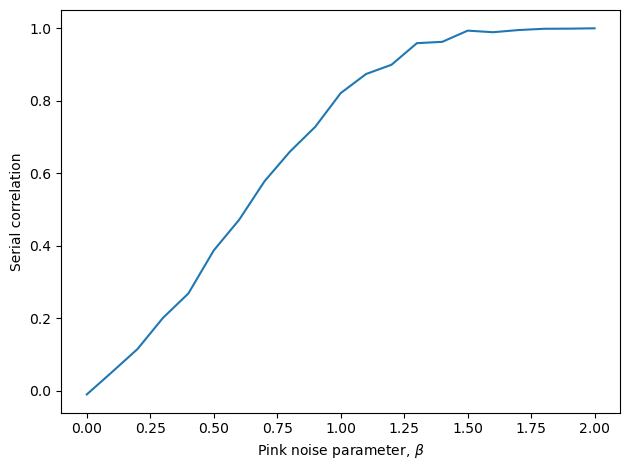

In [14]:
np.random.seed(19)

betas = np.linspace(0, 2, 21)
corrs = []

for beta in betas:
    signal =  PinkNoise(beta=beta)
    wave = signal.make_wave(duration=1.0, framerate=11025)
    corr = serial_corr(wave)
    corrs.append(corr)
    
plt.plot(betas, corrs)
decorate(xlabel=r'Pink noise parameter, $\beta$',
         ylabel='Serial correlation')

The autocorrelation function calls `serial_corr` with different values of `lag`.

In [15]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    
    returns: tuple of sequences (lags, corrs)
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

Now we can plot autocorrelation for pink noise with various values of $\beta$.

In [16]:
def plot_pink_autocorr(beta, label):
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=1.0, framerate=10000)
    lags, corrs = autocorr(wave)
    plt.plot(lags, corrs, label=label)

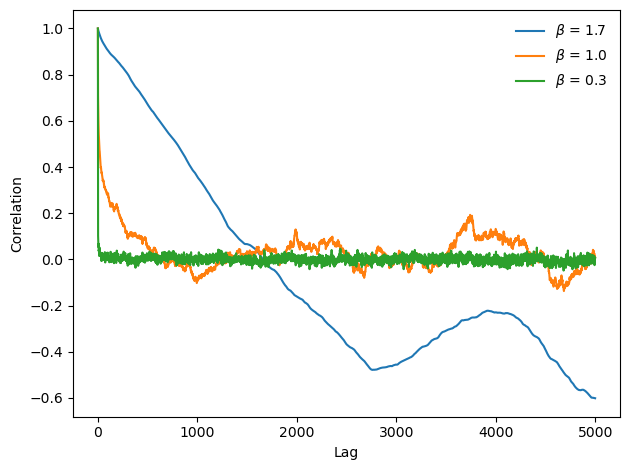

In [17]:
np.random.seed(19)

for beta in [1.7, 1.0, 0.3]:
    label = r'$\beta$ = %.1f' % beta
    plot_pink_autocorr(beta, label)

decorate(xlabel='Lag', 
         ylabel='Correlation')

For low values of $\beta$, the autocorrelation function drops off quickly.  As $\beta$ increases, pink noise shows more long range dependency.

Now let's investigate using autocorrelation for pitch tracking.  I'll load a recording of someone singing a chirp:

In [18]:
if not os.path.exists('28042__bcjordan__voicedownbew.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav

In [19]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

The spectrum tells us what frequencies are present, but for chirps, the frequency components are blurred over a range:

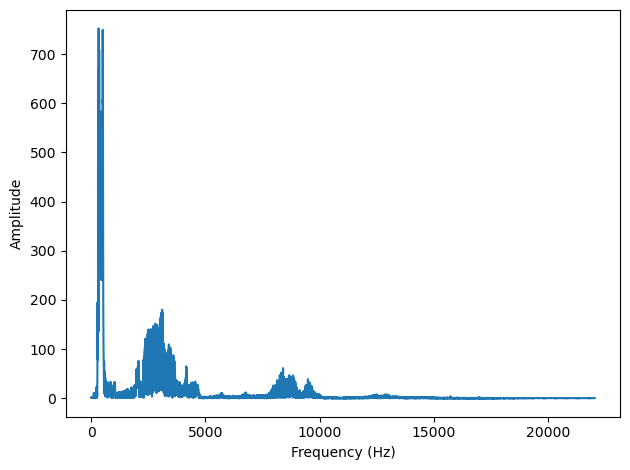

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

The spectrogram gives a better picture of how the components vary over time:

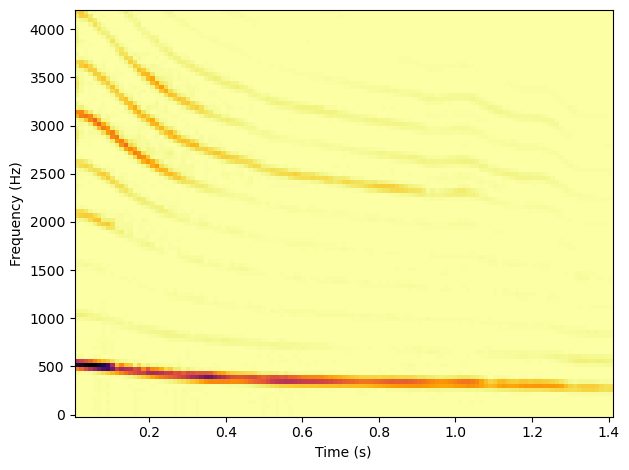

In [21]:
spectro = wave.make_spectrogram(seg_length=1024)
spectro.plot(high=4200)
decorate(xlabel='Time (s)', 
                 ylabel='Frequency (Hz)')

We can see the fundamental frequency clearly, starting near 500 Hz and dropping.  Some of the harmonics are also visible.

To track the fundamental frequency, we can take a short window:

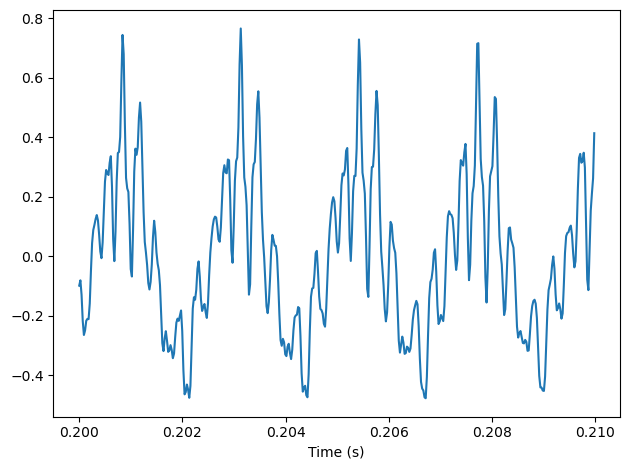

In [22]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
segment.plot()
decorate(xlabel='Time (s)')

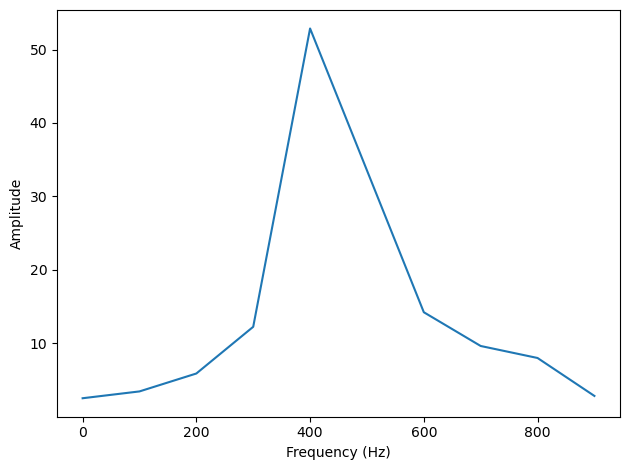

In [23]:
spectrum = segment.make_spectrum()
spectrum.plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

The spectrum shows a clear peak near 400 Hz, but we can't get an very accurate estimate of frequency, partly because the peak is blurry, and partly because even if it were a perfect spike, the frequency resolution is not very good.

In [24]:
len(segment), segment.framerate, spectrum.freq_res

(441, 44100, 100.22727272727273)

Each element of the spectrum spans a range of 100 Hz, so we can't get an accurate estimate of the fundamental frequency.  

For signals that are at least approximately periodic, we can do better by estimating the length of the period.

The following function plots the segment, and a shifted version of the segment, and computes the correlation between them:

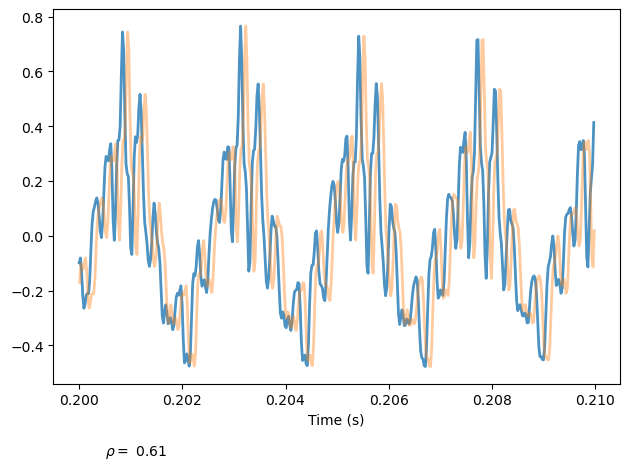

In [25]:
def plot_shifted(wave, offset=0.001, start=0.2):
    segment1 = wave.segment(start=start, duration=0.01)
    segment1.plot(linewidth=2, alpha=0.8)

    # start earlier and then shift times to line up
    segment2 = wave.segment(start=start-offset, duration=0.01)
    segment2.shift(offset)
    segment2.plot(linewidth=2, alpha=0.4)

    corr = segment1.corr(segment2)
    text = r'$\rho =$ %.2g' % corr
    plt.text(segment1.start+0.0005, -0.8, text)
    decorate(xlabel='Time (s)')

plot_shifted(wave, 0.0001)

With a small shift the segments are still moderately correlated.  As the shift increases, the correlation falls for a while, then rises again, peaking when the shift equals the period of the signal.

You can use the following interaction to search for the shift that maximizes correlation:

In [26]:
end = 0.004
slider1 = widgets.FloatSlider(min=0, max=end, step=end/40, value=0)
slider2 = widgets.FloatSlider(min=0.1, max=0.5, step=0.05, value=0.2)
interact(plot_shifted, wave=fixed(wave), offset=slider1, start=slider2);

interactive(children=(FloatSlider(value=0.0, description='offset', max=0.004, step=0.0001), FloatSlider(value=…

The `autocorr` function automates this process by computing the correlation for each possible lag, up to half the length of the wave.

The following figure shows this autocorrelation as a function of lag:

In [27]:
wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)

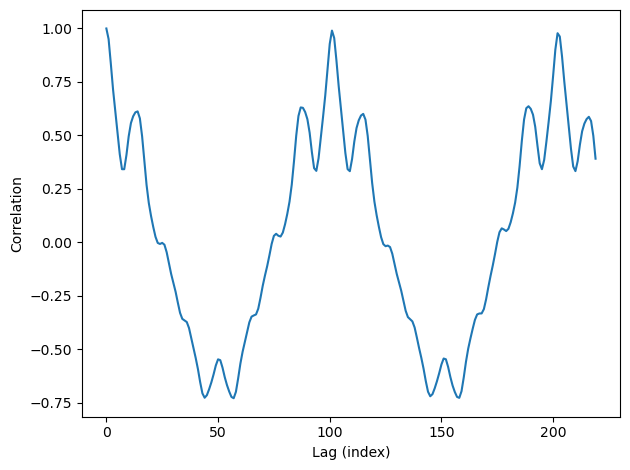

In [28]:
lags, corrs = autocorr(segment)
plt.plot(lags, corrs)
decorate(xlabel='Lag (index)', ylabel='Correlation')

The first peak (other than 0) is near lag=100.

We can use `argmax` to find the index of that peak:

In [29]:
low, high = 90, 110
lag = np.array(corrs[low:high]).argmax() + low
lag

101

We can convert from an index to a time in seconds:

In [30]:
period = lag / segment.framerate
period

0.002290249433106576

Given the period in seconds, we can compute frequency:

In [31]:
frequency = 1 / period
frequency

436.63366336633663

This should be a better estimate of the fundamental frequency.  We can approximate the resolution of this estimate by computing how much we would be off by if the index were off by 1:

In [32]:
segment.framerate / 102, segment.framerate / 100

(432.3529411764706, 441.0)

The range is less than 10 Hz.

The function I wrote to compute autocorrelations is slow; `np.correlate` is much faster.

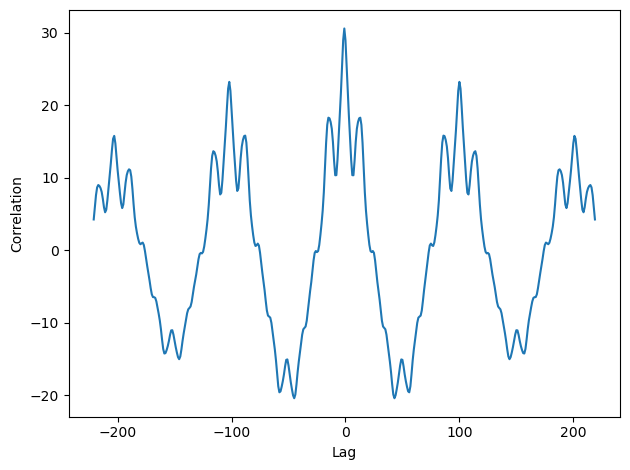

In [33]:
N = len(segment)
corrs2 = np.correlate(segment.ys, segment.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate(xlabel='Lag', ylabel='Correlation')

`np.correlate` computes correlations for positive and negative lags, so lag=0 is in the middle.  For our purposes, we only care about positive lags.

Also, `np.correlate` doesn't correct for the fact that the number of overlapping elements changes as the lag increases.

The following code selects the second half of the results and corrects for the length of the overlap:

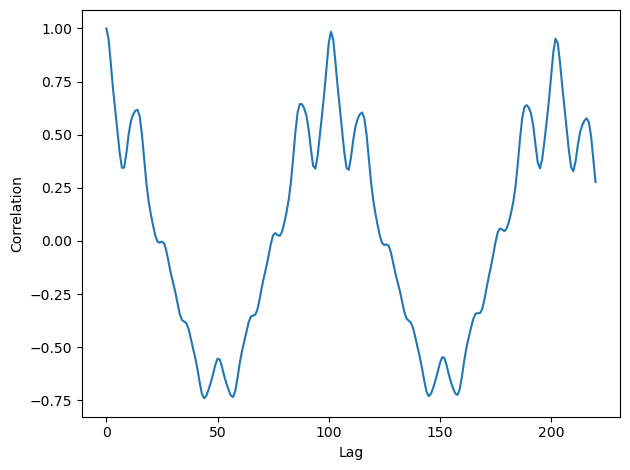

In [34]:
N = len(corrs2)
lengths = range(N, N//2, -1)

half = corrs2[N//2:].copy()
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag', ylabel='Correlation')

Now the result is similar to what we computed before.

If we plot the results computed by NumPy and my implementation, they are visually similar.  They are not quite identical because my version and theirs are normalized differently.

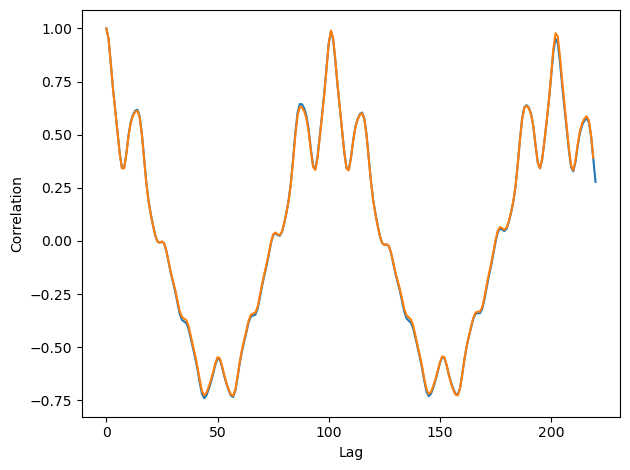

In [35]:
plt.plot(half)
plt.plot(corrs)
decorate(xlabel='Lag', ylabel='Correlation')

The difference between the NumPy implementation and mine is less than 0.02 over most of the range.

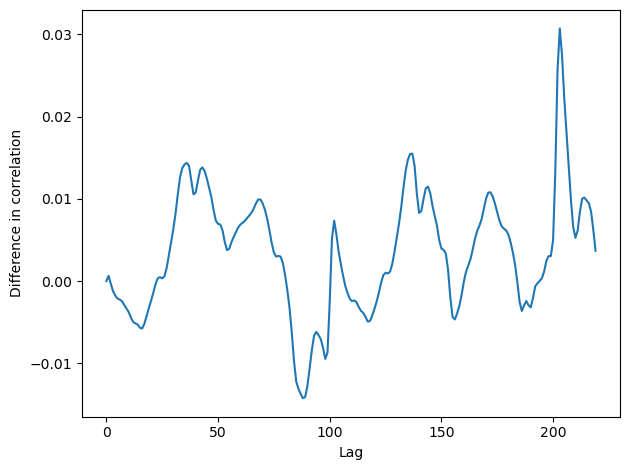

In [36]:
diff = corrs - half[:-1]
plt.plot(diff)
decorate(xlabel='Lag', ylabel='Difference in correlation')